In [85]:
#library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression   
import joblib

In [30]:
#load the dataset
csv_path = r"C:\Users\fedi\Documents\ESEN-HACK\100_pet_sales.csv"
df = pd.read_csv(csv_path, parse_dates=['order_date'])

In [3]:
# Quick peek at the first few rows
print(" First 5 rows of raw data:")
print(df.head(), "\n")

 First 5 rows of raw data:
  product_name animal_type category  price  sales order_date  month  weekday  \
0     Dog Food         dog     Food   20.0    120 2024-04-12      4        4   
1     Cat Food         cat     Food   18.0    100 2024-12-14     12        5   
2      Dog Toy         dog      Toy   15.0     90 2024-09-27      9        4   
3      Cat Toy         cat      Toy   12.0     80 2024-04-16      4        1   
4    Dog Leash         dog    Leash   25.0    150 2024-03-12      3        1   

   is_discounted  discount_pct  avg_review_score  num_reviews  in_stock  \
0          False             0              4.93          263      True   
1           True            30              2.87          430     False   
2          False             0              4.44           34      True   
3          False             0              3.72          205     False   
4           True            20              2.80           80     False   

   stock_left  ad_spend  click_through_ra

In [31]:
# Ensure 'sales' is numeric; if not, coerce to NaN and fill with the column mean
df['sales'] = pd.to_numeric(df['sales'], errors='coerce')
df['sales'].fillna(df['sales'].mean(), inplace=True)

C:\Users\fedi\AppData\Local\Temp\ipykernel_13212\2459044603.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sales'].fillna(df['sales'].mean(), inplace=True)


In [32]:
# Ensure 'price' is numeric; if not, coerce to NaN and fill with the column median
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['price'].fillna(df['price'].median(), inplace=True)


C:\Users\fedi\AppData\Local\Temp\ipykernel_13212\2815247116.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(df['price'].median(), inplace=True)


In [33]:
# Convert boolean columns to integers (0 or 1)
df['in_stock'] = df['in_stock'].astype(int)
df['holiday_season'] = df['holiday_season'].astype(int)
df['is_discounted'] = df['is_discounted'].astype(int)

In [34]:
# Convert other numeric-ish columns to numeric dtype, filling any missing values
df['discount_pct'] = pd.to_numeric(df['discount_pct'], errors='coerce').fillna(0.0)
df['avg_review_score'] = pd.to_numeric(df['avg_review_score'], errors='coerce').fillna(0.0)
df['num_reviews'] = pd.to_numeric(df['num_reviews'], errors='coerce').fillna(0)
df['stock_left'] = pd.to_numeric(df['stock_left'], errors='coerce').fillna(0)
df['ad_spend'] = pd.to_numeric(df['ad_spend'], errors='coerce').fillna(0.0)
df['click_through_rate'] = pd.to_numeric(df['click_through_rate'], errors='coerce').fillna(0.0)

In [8]:
#data after cleaning
print(">>> Data types after cleaning:")
print(df.dtypes, "\n")

>>> Data types after cleaning:
product_name                  object
animal_type                   object
category                      object
price                        float64
sales                          int64
order_date            datetime64[ns]
month                          int64
weekday                        int64
is_discounted                  int32
discount_pct                   int64
avg_review_score             float64
num_reviews                    int64
in_stock                       int32
stock_left                     int64
ad_spend                     float64
click_through_rate           float64
holiday_season                 int32
dtype: object 



In [35]:
# Extract "month" and "weekday" from the 'order_date' (we already parsed it above)
df['month'] = df['order_date'].dt.month
df['weekday'] = df['order_date'].dt.weekday

In [36]:
# One‐Hot Encode categorical columns: 'animal_type' & 'category'
#     After this, we get columns like 'animal_type_dog' (1 if dog, 0 if cat),
#     plus 'category_Bed', 'category_Collar', etc.
dummies = pd.get_dummies(df[['animal_type', 'category']], drop_first=True)
df = pd.concat([df, dummies], axis=1)

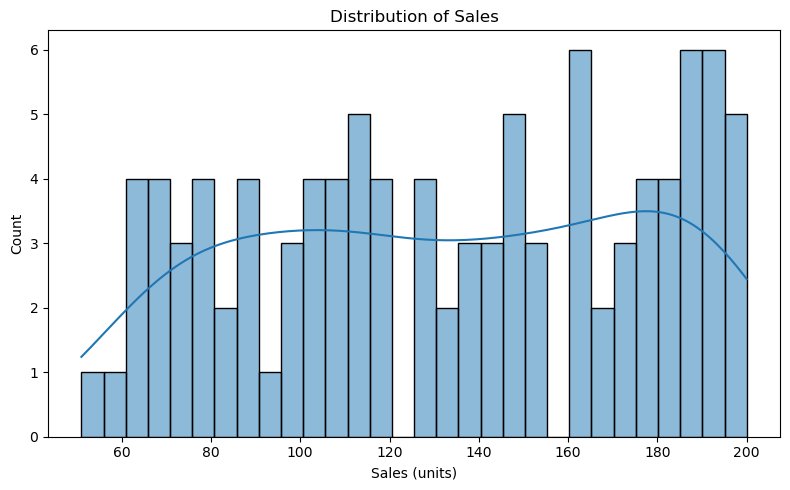

Saved plot → hist_sales.png


In [37]:
# 4.1 Histogram of 'sales' 
plt.figure(figsize=(8, 5))
sns.histplot(df['sales'], bins=30, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Sales (units)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("hist_sales.png")
plt.show()
plt.close()
print("Saved plot → hist_sales.png")


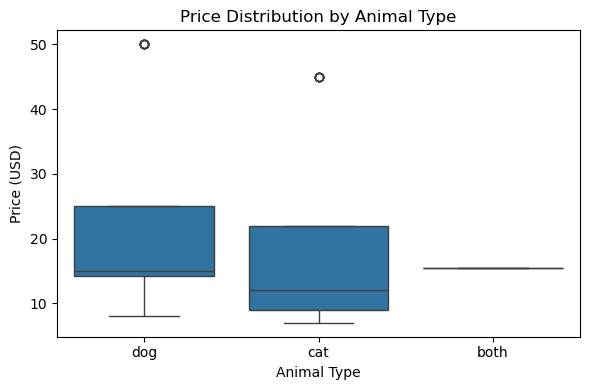

Saved plot → boxplot_price_by_animal.png


In [38]:
# 4.2 Boxplot of 'price' by 'animal_type' to compare cat vs. dog pricing
plt.figure(figsize=(6, 4))
sns.boxplot(x='animal_type', y='price', data=df)
plt.title("Price Distribution by Animal Type")
plt.xlabel("Animal Type")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.savefig("boxplot_price_by_animal.png")
plt.show()
plt.close()
print("Saved plot → boxplot_price_by_animal.png")

In [40]:
# select numeric and dummy columns for features
numeric_cols = [
    'price', 'month', 'weekday', 'is_discounted', 'discount_pct',
    'avg_review_score', 'num_reviews', 'in_stock', 'stock_left',
    'ad_spend', 'click_through_rate', 'holiday_season'
]
dummy_cols = [col for col in df.columns if col.startswith('animal_type_') or col.startswith('category_')]
all_corr_cols = numeric_cols + dummy_cols

In [41]:
# Define features (X) and target (y)
feature_cols = all_corr_cols
X = df[feature_cols]
y = df['sales']


In [42]:
# Sanity check: make sure none of the feature columns are missing
missing_cols = [col for col in feature_cols if col not in X.columns]
if missing_cols:
    raise ValueError(f"Missing columns in X: {missing_cols}")
print("✅ All feature columns are present.\n")

✅ All feature columns are present.



In [95]:
# Split into train (70%) and test (30%)
variances = df.var(numeric_only=True).sort_values(ascending=False)
top_features = variances.head(5).index.tolist()

# Use these columns as X
X = df[top_features]

# Now split as usual
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print(f"Training set size:  {X_train.shape[0]} rows")
print(f"Testing set size:   {X_test.shape[0]} rows\n")
print(np.shape(y_train))
print(np.shape(y_test))

Training set size:  80 rows
Testing set size:   20 rows

(80,)
(20,)


In [96]:
#  MODEL SELECTION & HYPERPARAMETER TUNING (RANDOM FOREST)
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("Starting GridSearchCV for RandomForestRegressor...")
grid_search.fit(X_train, y_train)

best_forest = grid_search.best_estimator_
print("✔︎ Best hyperparameters:", grid_search.best_params_, "\n")

Starting GridSearchCV for RandomForestRegressor...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
✔︎ Best hyperparameters: {'max_depth': 10, 'n_estimators': 100} 



In [97]:
#  EVALUATE ON TEST SET

y_pred = best_forest.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print(f"MSE on test set:  {mse_test:.2f}")
print(f"R² on test set:   {r2_test:.2f}\n")

MSE on test set:  1.56
R² on test set:   1.00



C:\Users\fedi\AppData\Local\Temp\ipykernel_13212\749570533.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


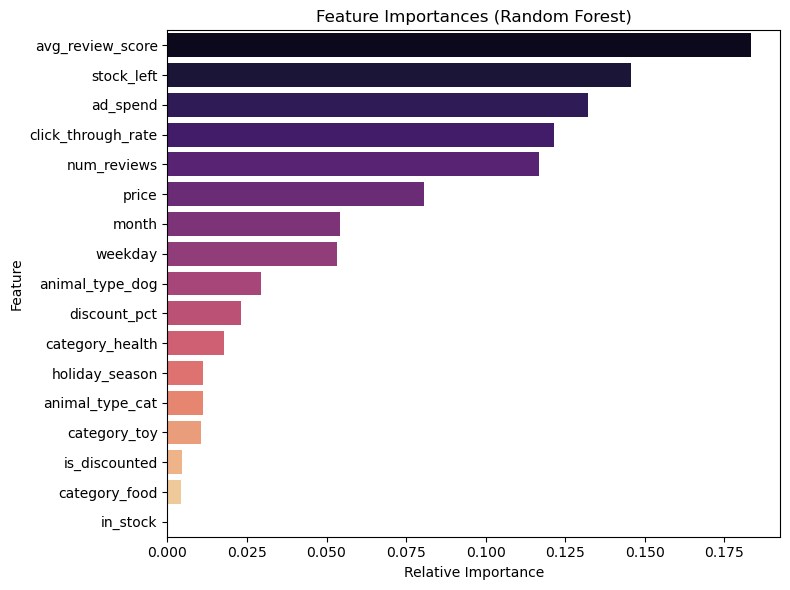

Saved plot → feature_importances_rf.png



In [88]:
#  PLOT FEATURE IMPORTANCES (SEABORN BARPLOT)
importances = best_forest.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    x='importance',
    y='feature',
    data=importance_df,
    palette='magma'
)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("feature_importances_rf.png")
plt.show()
plt.close()
print("Saved plot → feature_importances_rf.png\n")

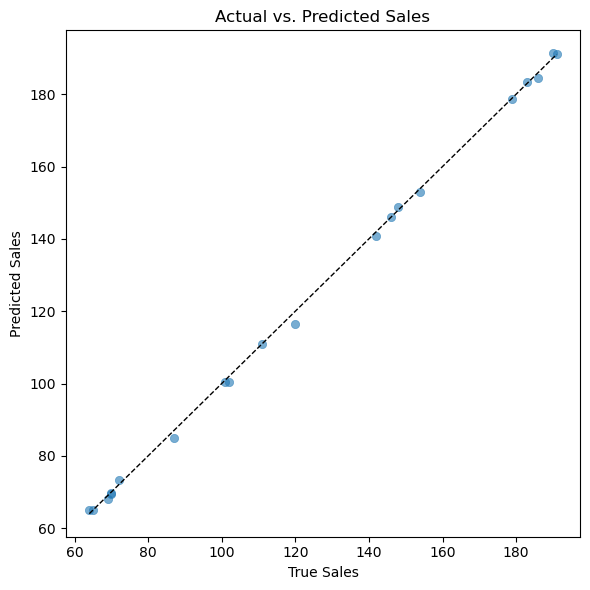

Saved plot → actual_vs_predicted_rf.png


In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))


sns.scatterplot(
    x=y_test,
    y=y_pred,
    alpha=0.6,
    edgecolor=None
)

min_val = y_test.min()
max_val = y_test.max()
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    'k--',     
    linewidth=1
)

plt.title("Actual vs. Predicted Sales")
plt.xlabel("True Sales")
plt.ylabel("Predicted Sales")

plt.tight_layout()
plt.savefig("actual_vs_predicted_rf.png")
plt.show()
plt.close()

print("Saved plot → actual_vs_predicted_rf.png")


In [23]:
# Serialize the trained model to disk
model_filename = "rf_sales_model.joblib"
joblib.dump(best_forest, model_filename)
print(f"✔︎ Saved trained model → {model_filename}\n")


✔︎ Saved trained model → rf_sales_model.joblib



In [24]:
# Print top‐selling and lowest‐selling products (by true sales)
top_idx = df['sales'].idxmax()
worst_idx = df['sales'].idxmin()

print(" Top‐selling product (true sales):")
print(df.loc[top_idx, ['product_name', 'animal_type', 'category', 'sales']], "\n")

print("  Lowest‐selling product (true sales):")
print(df.loc[worst_idx, ['product_name', 'animal_type', 'category', 'sales']], "\n")

 Top‐selling product (true sales):
product_name    Dog Treats
animal_type            dog
category            Treats
sales                  160
Name: 12, dtype: object 

  Lowest‐selling product (true sales):
product_name    Cat Collar
animal_type            cat
category            Collar
sales                   70
Name: 9, dtype: object 

